In [460]:
import numpy as np
import glob
import matplotlib.pyplot as plt
from scipy.stats import t
from scipy.stats import norm, laplace

In [492]:
jaw = "lower"
ids_test = np.load("../data/split/ids_test.npy")
y_acc = []
y_pred_acc = []
for id in ids_test:
    y = np.load(f"../data/final/{id}/labels_{jaw}_0.npy")
    y_pred = np.arange(0, 17)
    y_acc.append(y)
    y_pred_acc.append(y_pred)
y_acc = np.array(y_acc).reshape(-1)
y_pred = np.array(y_pred_acc).reshape(-1)
print(f"Accuracy: {np.sum(y_acc == y_pred) / len(y_acc)}")

Accuracy: 0.8859180035650623


In [485]:
ids = np.load("../data/split/ids_train.npy")
distance_map_acc = []
labels_acc = []
for id in ids:
    distance_map = np.load(f"../data/processed/{id}/distance_map_lower.npy")
    distance_map_acc.append(distance_map)
distance_map_acc = np.array(distance_map_acc)
labels_acc = np.array(labels_acc)

In [486]:
distance_map_mean = np.zeros((17, 17, 3))
distance_map_std = np.zeros((17, 17, 3))
for i in range(17):
    for j in range(17):
        x_distance_map = distance_map_acc[:, i, j, 0]
        y_distance_map = distance_map_acc[:, i, j, 1]
        z_distance_map = distance_map_acc[:, i, j, 2]
        for ii in range(3):
            distances = distance_map_acc[:, i, j, ii]
            p95, p5 = np.percentile(distances, [95, 5])
            distances = distances[distances < p95]
            distances = distances[distances > p5]
            mean, std = np.mean(distances), np.std(distances)
            distance_map_mean[i, j, ii] = mean
            distance_map_std[i, j, ii] = std

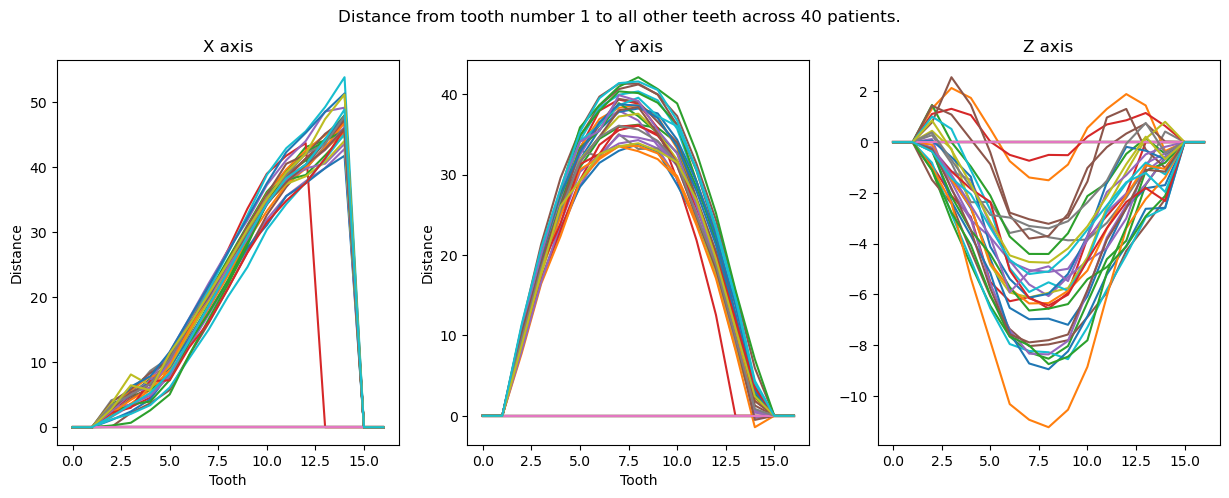

In [493]:
distance_map_mean = np.load("../data/statistics/distance_map_mean_lower.npy")
distance_map_std = np.load("../data/statistics/distance_map_std_lower.npy")
n = 40
tooth = 1
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
for i in range(n):
    distance_map_tooth_x = distance_map_acc[i, tooth, :, 0]
    distance_map_tooth_y = distance_map_acc[i, tooth, :, 1]
    distance_map_tooth_z = distance_map_acc[i, tooth, :, 2]
    distance_map_tooth_x[np.isnan(distance_map_tooth_x)] = 0
    distance_map_tooth_y[np.isnan(distance_map_tooth_y)] = 0
    distance_map_tooth_z[np.isnan(distance_map_tooth_z)] = 0
    ax[0].plot(np.arange(0, 17), distance_map_tooth_x)
    ax[1].plot(np.arange(0, 17), distance_map_tooth_y)
    ax[2].plot(np.arange(0, 17), distance_map_tooth_z)
ax[0].set_ylabel("Distance")
ax[0].set_xlabel("Tooth")
ax[1].set_ylabel("Distance")
ax[1].set_xlabel("Tooth")
ax[1].set_ylabel("Distance")
ax[1].set_xlabel("Tooth")
ax[0].set_title("X axis")
ax[1].set_title("Y axis")
ax[2].set_title("Z axis")
fig.suptitle(f"Distance from tooth number {tooth} to all other teeth across {n} patients.")
plt.show()

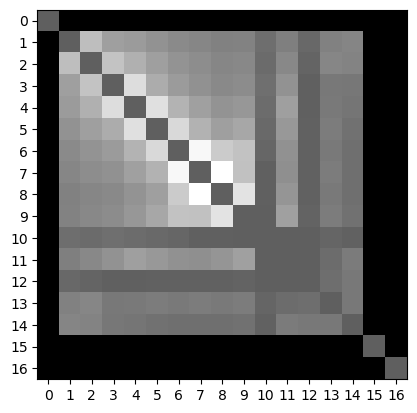

Labels [ 0  1  2  3  4  5  6  7  8  9 12 11 10 14 13 15 16]
Centroids [[  0.           0.           0.        ]
 [ 22.68617583  20.03660513 -91.23973258]
 [ 20.82440465  11.56809712 -90.83730874]
 [ 18.26734695   3.03618889 -90.49213809]
 [ 16.82415056  -3.6434789  -89.1930132 ]
 [ 13.90394477  -9.68509171 -87.51400151]
 [  9.51549301 -12.95462001 -86.52403513]
 [  5.05051869 -14.86396604 -85.98840107]
 [  0.53337333 -14.84692017 -85.81705716]
 [ -4.3886285  -13.68914135 -85.63653909]
 [-13.86045302   2.070705   -90.27754864]
 [-11.6600719   -4.06735856 -88.13857631]
 [ -8.59153482 -10.07360199 -86.51360547]
 [-20.70284103  18.30001844 -88.65626644]
 [-17.76740178   9.58510674 -89.66569819]
 [  0.           0.           0.        ]
 [  0.           0.           0.        ]]


In [491]:
import matplotlib.pyplot as plt

id = "0TMOBYXS"
labels = np.load(f"../data/final/{id}/labels_lower_0.npy")
centroids = np.load(f"../data/final/{id}/centroids_lower_0.npy")
score_map = np.load(f"../data/final/{id}/score_map_lower_0.npy")
plt.imshow(score_map, cmap="gray")
plt.xticks(np.arange(17))
plt.yticks(np.arange(17))
plt.show()
print(f"Labels {labels}")
print(f"Centroids {centroids}")

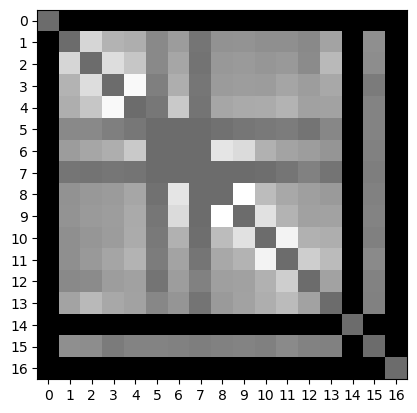

Labels [ 0  1  2  3  4  7  6  5  8  9 10 11 12 13 15 14 16]
Centroids [[  0.           0.           0.        ]
 [ 22.68617583  20.03660513 -91.23973258]
 [ 20.82440465  11.56809712 -90.83730874]
 [ 18.26734695   3.03618889 -90.49213809]
 [ 16.82415056  -3.6434789  -89.1930132 ]
 [  5.05051869 -14.86396604 -85.98840107]
 [  9.51549301 -12.95462001 -86.52403513]
 [ 13.90394477  -9.68509171 -87.51400151]
 [  0.53337333 -14.84692017 -85.81705716]
 [ -4.3886285  -13.68914135 -85.63653909]
 [ -8.59153482 -10.07360199 -86.51360547]
 [-11.6600719   -4.06735856 -88.13857631]
 [-13.86045302   2.070705   -90.27754864]
 [-17.76740178   9.58510674 -89.66569819]
 [  0.           0.           0.        ]
 [-20.70284103  18.30001844 -88.65626644]
 [  0.           0.           0.        ]]


In [474]:
import matplotlib.pyplot as plt

id = "0TMOBYXS"
labels = np.load(f"../data/final/{id}/labels_lower_0.npy")
centroids = np.load(f"../data/final/{id}/centroids_lower_0.npy")
score_map = np.load(f"../data/final/{id}/score_map_lower_0.npy")
plt.imshow(score_map, cmap="gray")
plt.xticks(np.arange(17))
plt.yticks(np.arange(17))
plt.show()
print(f"Labels {labels}")
print(f"Centroids {centroids}")